In [76]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, \
recall_score, f1_score, log_loss, confusion_matrix, \
    classification_report, roc_curve, auc, precision_recall_curve

from sklearn.preprocessing import StandardScaler

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

RAND = 10

# Лабораторная работа 

# Задача:
Компания, которая активно занимается Big Data и Data Science, хочет нанять специалистов по анализу данных среди людей, которые успешно проходят ее курсы. Многие люди регистрируются на обучение и компания хочет понимать, кто из этих кандидатов действительно хочет работать в компании после обучения или поиска новой работы, потому что это помогает снизить стоимость и время, а также повысить качество обучения, оптимизировать расписание курсов, понимать портрет кандидата. 


- enrolle_id - Уникальный идентификатор кандидата
- city - Код города
- city_ development _index - Индекс развития города (масштабированный)
- gender - пол кандидата
- relevent_experience - релевантный опыт кандидата
- enrolled_university - тип обучения в университете (если был)
- education_level - уровень образования кандидата
- major_discipline - основная специальность по образованию
- experience - общий стаж кандидата в годах
- company_size - размер компании в работниках
- company_type - тип работодателя
- lastnewjob - дельта в годах между предыдущей и текущей работах
- training_hours - кол-во завершенных часов обучения
- target 0 – Не ищу новую работу
- target 1 – Ищу новую работу



Спрогнозировать вероятность того, что кандидат будет искать новую работу или будет работать в компании (0 - не ищу новую работу), а также интерпретировать features при принятии решения сотрудника.

### Блок о изучении данных и статистики

In [78]:
df = pd.read_csv('../data/HR Data Science/aug_train.csv')

In [79]:
df[:5]

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [81]:
df.isna().sum()[df.isna().sum() > 0] / df.shape[0]

gender                 0.235306
enrolled_university    0.020148
education_level        0.024011
major_discipline       0.146832
experience             0.003393
company_size           0.309949
company_type           0.320493
last_new_job           0.022080
dtype: float64

In [82]:
df.fillna(df.mode().iloc[0], inplace=True)

Чем так плох дисбаланс классов?

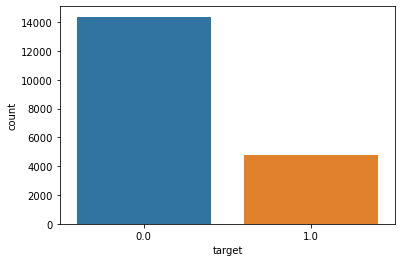

In [83]:
sns.countplot(x='target', data=df);

In [84]:
df.target.value_counts() / df.shape[0]

0.0    0.750652
1.0    0.249348
Name: target, dtype: float64

In [85]:
df[:5]

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,50-99,Pvt Ltd,never,83,0.0
3,33241,city_115,0.789,Male,No relevent experience,no_enrollment,Graduate,Business Degree,<1,50-99,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


### Переобразоваем категориальные данные в бинарные (one-hot encoding) и удаления столбца 'enrollee_id' т.к имеет уникальные значения.

In [86]:
df_label = pd.get_dummies(df.drop('enrollee_id', axis=1), drop_first=True)

In [87]:
df_label[:5]

,city_development_index,training_hours,target,city_city_10,city_city_100,city_city_101,city_city_102,city_city_103,city_city_104,city_city_105,...,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,0.920,36,1.0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.776,47,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0.624,83,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.789,52,1.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0.767,8,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [88]:
df_label.shape

(19158, 177)

### Разделения данных на тестовые и тренеровачные, так же удалятся целевая переменая из переменной X,чтобы модель могла использовать оставшиеся данные для обучения.

In [94]:
X = df_label.drop(['target'], axis=1)
y = df_label['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RAND)

Обязательно в классификации и в особенности при дисбалансе использовать параметр stratify, так он сохраняет исходное соотношение классов в train/test

In [95]:
y.value_counts() / len(y)

0.0    0.750652
1.0    0.249348
Name: target, dtype: float64

In [96]:
y_train.value_counts() / len(y_train)

0.0    0.75062
1.0    0.24938
Name: target, dtype: float64

In [97]:
y_test.value_counts() / len(y_test)

0.0    0.750783
1.0    0.249217
Name: target, dtype: float64

## Пробуем базовую модель классификации под названием "LogisticRegression" 

In [98]:
# обучаем Logistic Regression
lg = LogisticRegression(random_state=RAND)
lg.fit(X_train,y_train)

# получаем спрогнозированные метки классов
y_pred = lg.predict(X_test)
# получаем спрогнозированные вероятности
y_score = lg.predict_proba(X_test)

In [106]:
y_score

array([[0.87033775, 0.12966225],
       [0.92563157, 0.07436843],
       [0.71348822, 0.28651178],
       ...,
       [0.57434646, 0.42565354],
       [0.73414843, 0.26585157],
       [0.84272413, 0.15727587]])

In [99]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

- Функция для вывода метрик(оценки) предсказания модели.

In [108]:
def get_metrics(y_test, y_pred, y_score, name):
    """Вывод метрик для задачи классификации"""
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    # Основные метрики для задачи классификации
    df_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    df_metrics['ROC_AUC'] = roc_auc_score(y_test, y_score[:, 1])
    df_metrics['Precision'] = precision_score(y_test, y_pred)
    df_metrics['Recall'] = recall_score(y_test, y_pred)
    df_metrics['f1'] = f1_score(y_test, y_pred)
    df_metrics['Logloss'] = log_loss(y_test, y_score)

    return df_metrics

- Результаты Basline

In [3]:
metrics = get_metrics(y_test, y_pred, y_score, name='Baseline')
metrics

NameError: name 'get_metrics' is not defined

- Выводим график под кривой ROC-AUC для визуальной оценки модели.

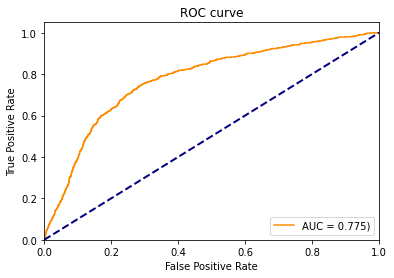

In [111]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

# auc - Compute Area Under the Curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)})')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# масштаб
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

# где расположена легенда
plt.legend(loc="lower right")
plt.show()

# Так у нашей модели дисбаланс классов мы будем использовать четыре разные техники для этого:
- Опция из под коробки 'class_weight' - который будет учитывать лучше дисбаланс классов
- Oversampling
- Undersampling
- SMOTE
По каждой отдельной техникой будет блок с информацией.В конце сравним результаты всех 5 видов модели включая 'Basline'

## class_weight

In [113]:
lg = LogisticRegression(class_weight='balanced', random_state=RAND)
lg.fit(X_train, y_train)

y_pred = lg.predict(X_test)
y_score = lg.predict_proba(X_test)

metrics = metrics.append(
    get_metrics(y_test, y_pred, y_score, name='ClassWeight'))
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Baseline,0.768528,0.774753,0.564151,0.313089,0.402694,0.473716
0,ClassWeight,0.735647,0.775689,0.479315,0.703665,0.570216,0.575661


- Выводим график под кривой ROC-AUC для визуальной оценки модели.

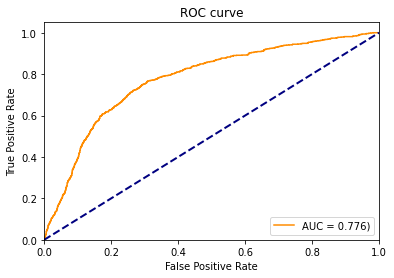

In [116]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[: , 1])

# auc - Compute Area Under the Curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)})')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# масштаб
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

# где расположена легенда
plt.legend(loc="lower right")
plt.show()

## Oversampling

- Oversampling (пересемплирование) — это метод увеличения количества экземпляров меньшинства (миноритарного класса) путем создания копий существующих данных или генерации новых данных. Основная цель — сбалансировать количество экземпляров каждого класса.

- Преимущества:

Увеличивает представительство миноритарного класса.
Снижает вероятность переобучения, так как все классы имеют большее количество экземпляров.
- Недостатки:

Может привести к переобучению, особенно если просто дублировать экземпляры, так как модель может запомнить повторяющиеся экземпляры.
Увеличивает размер данных, что может повысить требования к памяти и времени обучения.


<img src='https://dataaspirant.com/wp-content/uploads/2020/08/10-oversampling.png'>

In [117]:
# метод для OverSampling
from imblearn.over_sampling import RandomOverSampler

In [118]:
# делаем размерности классов 1 к 1, если 0.6 - то размер недостающего класса
# составляет 60% от большего класса

oversample = RandomOverSampler(sampling_strategy=1.0)
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [119]:
X_over.shape

(23008, 176)

In [120]:
X_train.shape

(15326, 176)

In [121]:
y_over.value_counts()

0.0    11504
1.0    11504
Name: target, dtype: int64

In [122]:
y_train.value_counts()

0.0    11504
1.0     3822
Name: target, dtype: int64

- Вывод результатов

In [124]:
lg = LogisticRegression(random_state=RAND)
lg.fit(X_over, y_over)

y_pred = lg.predict(X_test)
y_score = lg.predict_proba(X_test)

metrics = metrics.append(
    get_metrics(y_test, y_pred, y_score, name='OverSampling'))
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Baseline,0.768528,0.774753,0.564151,0.313089,0.402694,0.473716
0,ClassWeight,0.735647,0.775689,0.479315,0.703665,0.570216,0.575661
0,OverSampling,0.730689,0.774682,0.473356,0.716230,0.570000,0.579740


- Выводим график под кривой ROC-AUC для визуальной оценки модели.

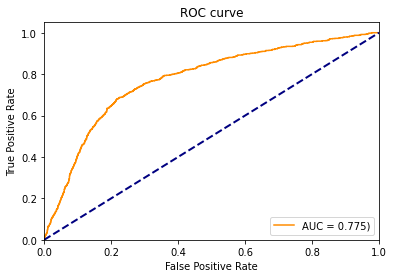

In [125]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

# auc - Compute Area Under the Curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)})')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# масштаб
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

# где расположена легенда
plt.legend(loc="lower right")
plt.show()

- Undersampling (недосемплирование) — это метод уменьшения количества экземпляров большинства (мажоритарного класса) путем случайного удаления данных. Основная цель — сбалансировать количество экземпляров каждого класса.

- Преимущества:

Уменьшает размер данных, что снижает требования к памяти и времени обучения.
Снижает вероятность переобучения на миноритарном классе.
- Недостатки:

Может приводить к потере важной информации из мажоритарного класса.
Может ухудшить производительность модели, если мажоритарный класс содержит важные признаки.

Undersampling – это дублирование примеров мажоритарного (наибольшего) класса. В зависимости от того, какое соотношение классов необходимо, выбирается количество случайных записей для дублирования.

<img src='https://dataaspirant.com/wp-content/uploads/2020/08/17-undersampling.png'>

In [126]:
# метод для UnderSampling
from imblearn.under_sampling import RandomUnderSampler

In [127]:
undersample = RandomUnderSampler(sampling_strategy=1.0) #sampling_strategy = majority
X_under, y_under = undersample.fit_resample(X_train, y_train)

In [128]:
X_under.shape

(7644, 176)

In [129]:
X_train.shape

(15326, 176)

In [130]:
y_under.value_counts()

0.0    3822
1.0    3822
Name: target, dtype: int64

- Выводим результаты

In [131]:
lg = LogisticRegression(random_state=RAND)
lg.fit(X_under, y_under)

y_pred = lg.predict(X_test)
y_score = lg.predict_proba(X_test)

metrics = metrics.append(
    get_metrics(y_test, y_pred, y_score, name='UnderSampling'))
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Baseline,0.768528,0.774753,0.564151,0.313089,0.402694,0.473716
0,ClassWeight,0.735647,0.775689,0.479315,0.703665,0.570216,0.575661
0,OverSampling,0.730689,0.774682,0.473356,0.716230,0.570000,0.579740
0,UnderSampling,0.732516,0.773067,0.475212,0.702618,0.566962,0.577055


- Выводим график под кривой ROC-AUC для визуальной оценки модели.

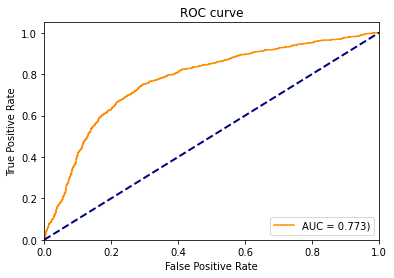

In [132]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[: ,1])

# auc - Compute Area Under the Curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)})')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# масштаб
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

# где расположена легенда
plt.legend(loc="lower right")
plt.show()

- SMOTE — это продвинутый метод пересемплирования, который синтетически генерирует новые экземпляры миноритарного класса, вместо того чтобы просто дублировать существующие. SMOTE создает новые данные, интерполируя между существующими экземплярами миноритарного класса.

- Преимущества:

Увеличивает разнообразие данных миноритарного класса.
Снижает вероятность переобучения, так как создает новые экземпляры, а не дублирует существующие.
- Недостатки:

Может создавать экземпляры, которые не являются репрезентативными для миноритарного класса.
Может усложнить модель, если синтетические данные не точно отражают распределение реальных данных.


In [133]:
from imblearn.over_sampling import SMOTE

In [134]:
smote = SMOTE(k_neighbors=5)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

Разница между Oversampling и SMOTE

[22, 23, 26, 30, 45]

- Oversampling

[22, 23, 26, 30, 45,___22, 23, 26, 30, 45, 23, 26]

- SMOTE

[22, 23, 26, 30, 45, **___24, 25**, 23, 22, 45, **31**, **29**]

In [135]:
X_smote.describe(include=float)

,city_development_index
count,23008.000000
mean,0.803217
std,0.131449
min,0.448000
25%,0.646348
50%,0.884000
75%,0.920000
max,0.949000


In [136]:
X_train.describe(include=float)

,city_development_index
count,15326.000000
mean,0.829015
std,0.123244
min,0.448000
25%,0.740000
50%,0.910000
75%,0.920000
max,0.949000


In [137]:
y_train.value_counts()

0.0    11504
1.0     3822
Name: target, dtype: int64

In [138]:
y_smote.value_counts()

0.0    11504
1.0    11504
Name: target, dtype: int64

- Обучения модели

In [139]:
lg = LogisticRegression(random_state=RAND)
lg.fit(X_smote, y_smote)

y_pred = lg.predict(X_test)
y_score = lg.predict_proba(X_test)

metrics = metrics.append(
    get_metrics(y_test, y_pred, y_score, name='SMOTE'))
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Baseline,0.768528,0.774753,0.564151,0.313089,0.402694,0.473716
0,ClassWeight,0.735647,0.775689,0.479315,0.703665,0.570216,0.575661
0,OverSampling,0.730689,0.774682,0.473356,0.716230,0.570000,0.579740
0,UnderSampling,0.732516,0.773067,0.475212,0.702618,0.566962,0.577055
0,SMOTE,0.749478,0.746378,0.497062,0.442932,0.468439,0.522463


- Выводим график под кривой ROC-AUC для визуальной оценки модели.

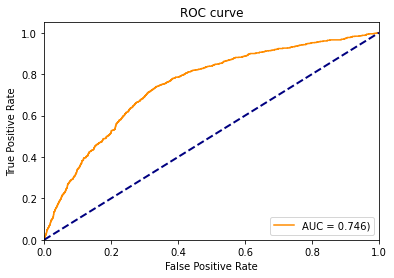

In [140]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

# auc - Compute Area Under the Curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)})')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# масштаб
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

# где расположена легенда
plt.legend(loc="lower right")
plt.show()

Больше про SMOTE https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

# Results

In [141]:
metrics.set_index('model', inplace=True)

In [142]:
round(metrics, 4)

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
Baseline,0.7685,0.7748,0.5642,0.3131,0.4027,0.4737
ClassWeight,0.7356,0.7757,0.4793,0.7037,0.5702,0.5757
OverSampling,0.7307,0.7747,0.4734,0.7162,0.5700,0.5797
UnderSampling,0.7325,0.7731,0.4752,0.7026,0.5670,0.5771
SMOTE,0.7495,0.7464,0.4971,0.4429,0.4684,0.5225
